# DPhi Bootcamp - Natural Language Processing
##### by John Dale Vacaro, 12 Feb 2022

### Methodology

1.  Problem Statement
2.  Data Pre-Processing
3.  Exploratory Data Analysis
4.  Text Pre-Processing
5.  Data Modeling & Evaluation
    * 5.1 Train Test Split
    * 5.2 Sentiment Analysis
    * 5.3 Bag of Words
    * 5.4 Logistic Regression
    * 5.6 Gradient Boosted Decision Tree
    * 5.7 Decision Tree
    * 5.8 Random Forest
6. Conclusion

## 1. Problem Statement

#### Work on a dataset that contains news headlines - which are aimed to be written in a sarcastic manner by the news author. My job here is to build our NLP models and predict whether the headline is sarcastic or not.

#### This problem represents a binary classification problem as the news headlines need to be classified betweeen 2 categories:

1. Sarcastic (1)
2. Not Sarcastic (0)

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import re
import nltk
import string

from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter 
from textblob import TextBlob 
from wordcloud import WordCloud 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings("ignore")

#nltk.download('stopwords')
#nltk.download('punkt')

In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

macOS-10.16-x86_64-i386-64bit
Python 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:38) 
[Clang 11.1.0 ]
NumPy 1.19.5
SciPy 1.8.0
Scikit-Learn 0.24.2


#### Install Dependencies
- pip install textsearch
- pip install contractions
- pip install wordcloud
- pip install text blob
- pip install google-colab

In [5]:
df = pd.read_csv("Train_Dataset.csv")
df_org = df
df.head()

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


## 2. Data Pre-Processing

In [6]:
# DUPLICATES Check

print("Current Number of Columns and Row : " + format(df.shape))
print("-------------------------------------------------------")
print("Number of Duplicates : " + format(df.duplicated().sum()))


Current Number of Columns and Row : (44262, 2)
-------------------------------------------------------
Number of Duplicates : 17204


In [7]:
# DROP DUPLICATES

df.drop_duplicates(keep="first", inplace=True)

print("New Number of Columns and Row : " + str(format(df.shape)))
print("-------------------------------------------------------")
print("Number of Duplicates : " + format(df.duplicated().sum()))


New Number of Columns and Row : (27058, 2)
-------------------------------------------------------
Number of Duplicates : 0


In [8]:
# (NaN, NAN, na) VALUES CHECK

print("Number of <Nan, NAN, na> values : " + str(df.isna().sum()))

Number of <Nan, NAN, na> values : headline        0
is_sarcastic    0
dtype: int64


In [9]:
# NULL/ MISSING VALUES Check

print("Null or Missing Values : " + str(df.isnull().values.any()))

Null or Missing Values : False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27058 entries, 0 to 44253
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      27058 non-null  object
 1   is_sarcastic  27058 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 634.2+ KB


In [11]:
df.describe()

,is_sarcastic
count,27058.000000
mean,0.469362
std,0.499070
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 3. Exploratory Data Analysis

0    14358
1    12700
Name: is_sarcastic, dtype: int64


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

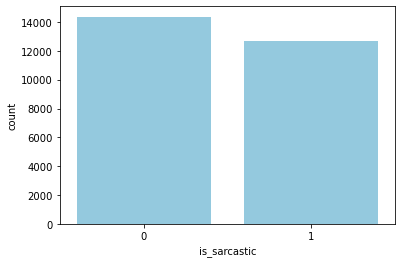

In [12]:
# DISTRIBUTION Check

print(df["is_sarcastic"].value_counts())

sns.countplot(df["is_sarcastic"], color="skyblue")

# Not Sarcastic Headlines > Sarcastic Headlines by 13%

In [13]:
sarcastic = df['headline'][df['is_sarcastic']==1]
not_sarcastic = df['headline'][df['is_sarcastic']==0]

#### Sarcasm

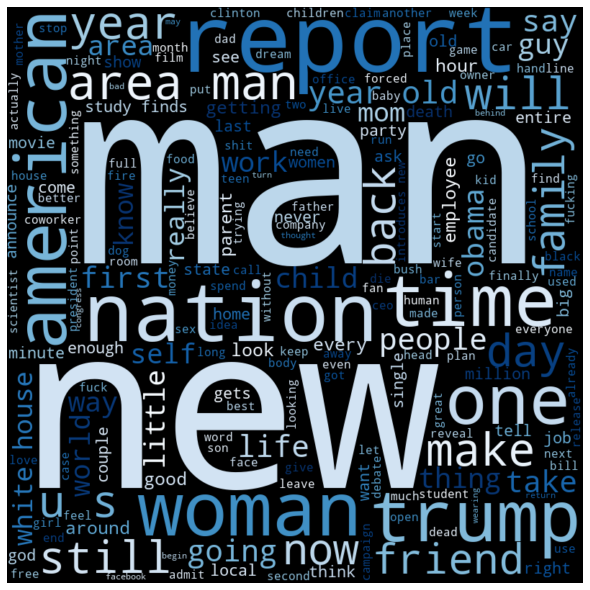

In [14]:
# WordCloud - SARCASTIC

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                colormap = "Blues",
                min_font_size = 10).generate(' '.join(sarcastic))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Not Sarcasm

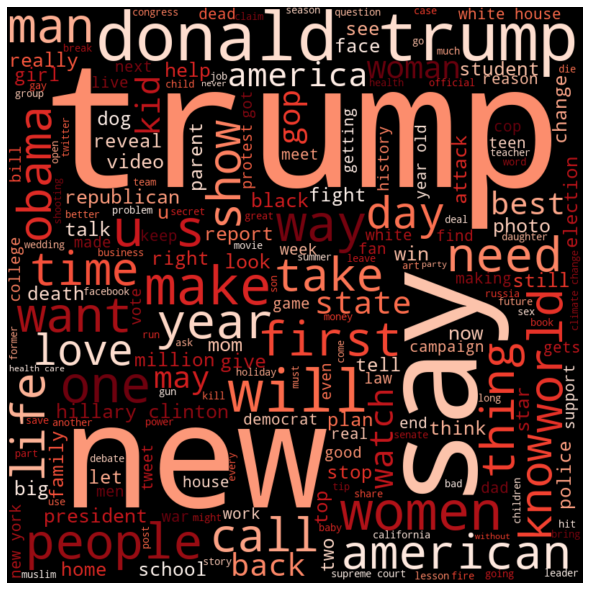

In [15]:
# WordCloud - SARCASTIC

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                colormap = "Reds",
                min_font_size = 10).generate(' '.join(not_sarcastic))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## 4. Text Pre-Processing

In [16]:
# Removing Stopwords and Normalization

stop_words = stopwords.words('english')

def normalize_document(doc):

    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.strip()
    doc = contractions.fix(doc)
    doc = word_tokenize(doc)
    doc = [doc for doc in doc if doc not in stop_words]
    doc = ' '.join(doc)
    
    return doc

# Vectorize
normalize_corpus = np.vectorize(normalize_document)

# Normalize
norm_corpus = normalize_corpus(list(df['headline']))

## 5. Data Modeling & Evaluation

### NLP Features

- Word Count: total number of words in the documents
- Character Count: total number of characters in the documents
- Average Word Density: average length of the words used in the documents
- Puncutation Count: total number of punctuation marks in the documents
- Upper Case Count: total number of upper count words in the documents
- Title Word Count: total number of proper case (title) words in the documents

### 5.1 Train-Test Split

In [17]:
X = df.drop(['is_sarcastic'], axis = 1)
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test  : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test  : " + str(y_test.shape))

X_train : (21646, 1)
X_test  : (5412, 1)
y_train : (21646,)
y_test  : (5412,)


In [18]:
# TRAIN DATA

# Total Characters
X_train['char_count'] = X_train['headline'].apply(len)
# Total Words
X_train['word_count'] = X_train['headline'].apply(lambda x: len(x.split()))
# Average Word Density
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
# Total Punctuations
X_train['punctuation_count'] = X_train['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

# TEST DATA

# Total Characters
X_test['char_count'] = X_test['headline'].apply(len)
# Total Words
X_test['word_count'] = X_test['headline'].apply(lambda x: len(x.split()))
# Average Word Density
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)
# Total Punctuations
X_test['punctuation_count'] = X_test['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 

X_train.head()

,headline,char_count,word_count,word_density,punctuation_count
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0
22481,less than half of the money pledged to fight e...,77,13,5.500000,0
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0


### 5.2 Sentiment Analysis

In [19]:
# Review Statement
x_train_sa = X_train['headline'].apply(lambda row: TextBlob(row).sentiment)
# Polarity Scores
X_train['Polarity'] = [obj.polarity for obj in x_train_sa.values]
# # Subjectivity Scores
X_train['Subjectivity'] = [obj.subjectivity for obj in x_train_sa.values]

# Review Statement
x_test_sa = X_test['headline'].apply(lambda row: TextBlob(row).sentiment)
# Polarity Scores
X_test['Polarity'] = [obj.polarity for obj in x_test_sa.values]
# Subjectivity Scores
X_test['Subjectivity'] = [obj.subjectivity for obj in x_test_sa.values]


X_train.head()

,headline,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0,0.000000,0.000000
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0,0.000000,0.000000
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0,0.265000,0.510000
22481,less than half of the money pledged to fight e...,77,13,5.500000,0,-0.166667,0.116667
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0,0.000000,0.500000


### 5.3 Bag of Words

In [20]:
stop_words = stopwords.words('english')

# Text Stemming and Vectorizing

ps = PorterStemmer()

def transform_doc(docs):
    
    docs = str(docs).lower()
    docs = contractions.fix(docs)
    docs = re.sub(r'[^a-zA-Z]',r' ', docs)
    docs = re.sub(r'nbsp', r'', docs)
    docs = re.sub(' +', ' ', docs)
    docs = ' '.join([ps.stem(word) for word in docs.split()])
    docs = ' '.join([word for word in docs.split() if word not in stop_words])
    
    return docs

# Vectorize
stp = np.vectorize(transform_doc)

In [21]:
X_train['Clean Headline'] = stp(X_train['headline'].values)
X_test['Clean Headline'] = stp(X_test['headline'].values)

X_train.head()

,headline,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,Clean Headline
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0,0.000000,0.000000,frazzl robert mueller walk around piec russia ...
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0,0.000000,0.000000,ballet hisp nico give latino artist voic deserv
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0,0.265000,0.510000,porn actress veri nearli appear enjoy ejacul face
22481,less than half of the money pledged to fight e...,77,13,5.500000,0,-0.166667,0.116667,less half money pledg fight ebola reach affect...
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0,0.000000,0.500000,smoke ban collaps fragil prison economi


In [22]:
X_train_data2 = X_train.drop(['headline', 'Clean Headline'], axis=1).reset_index(drop=True)
X_test_data2 = X_test.drop(['headline', 'Clean Headline'], axis=1).reset_index(drop=True)


X_train_data2.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
0,100,15,6.250000,0,0.000000,0.000000
1,62,10,5.636364,0,0.000000,0.000000
2,61,10,5.545455,0,0.265000,0.510000
3,77,13,5.500000,0,-0.166667,0.116667
4,44,6,6.285714,0,0.000000,0.500000


In [23]:
# Vectorizer
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# Vectorizer to Numpy Array
X_traincv = cv.fit_transform(X_train['Clean Headline']).toarray()
# To Pandas DF
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

# Vectorizer to Numpy Array
X_testcv = cv.transform(X_test['Clean Headline']).toarray()
# To Pandas DF
X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names())


X_traincv.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,...,zogbi,zohan,zombi,zone,zoo,zookeep,zoologist,zoom,zucker,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_train = pd.concat([X_train_data2, X_traincv], axis=1)
X_test = pd.concat([X_test_data2, X_testcv], axis=1)

X_train.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,aaa,aaron,aarp,aatish,...,zogbi,zohan,zombi,zone,zoo,zookeep,zoologist,zoom,zucker,zuckerberg
0,100,15,6.250000,0,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,62,10,5.636364,0,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61,10,5.545455,0,0.265000,0.510000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77,13,5.500000,0,-0.166667,0.116667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,6,6.285714,0,0.000000,0.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.4 Logistic Regression

In [25]:
X_train.shape, y_train.shape, X_test.shape

((21646, 15622), (21646,), (5412, 15622))

In [26]:
lr = LogisticRegression(C=1, random_state=150, solver='liblinear', max_iter=100, verbose=0)

lr.fit(X_train, y_train)
lr_pred_test = lr.predict(X_test)


In [27]:
print(classification_report(y_test, lr_pred_test, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.82      0.86      0.84      2901
    Sarcastic       0.83      0.77      0.80      2511

     accuracy                           0.82      5412
    macro avg       0.82      0.82      0.82      5412
 weighted avg       0.82      0.82      0.82      5412



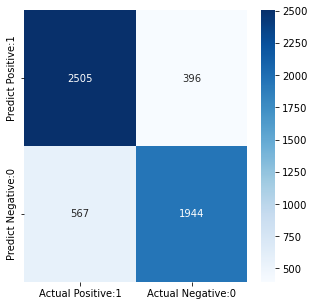

In [28]:
cm = confusion_matrix(y_test, lr_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])


fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues');


In [ ]:
# y_pred_DT = classifier.predict(X_test)
# y_pred_DT

In [ ]:
# cm_DT = confusion_matrix(y_test, y_pred_DT) 
# cm_DT

### 5.5 Gradient Boosted Decision Tree

In [38]:
gbc_model = GradientBoostingClassifier()

In [39]:
gbc_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5],
    'n_estimators': [10, 20, 30, 50]
}


In [40]:
gbc_clf = GridSearchCV(
    estimator=gbc_model, 
    param_grid=gbc_params, 
    return_train_score=True, 
    scoring="average_precision",
    cv=3, 
    verbose=3
)

In [41]:
gbc_clf.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=(train=0.522, test=0.515) total time=  12.7s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=(train=0.523, test=0.526) total time=  12.8s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=(train=0.533, test=0.535) total time=  13.9s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=(train=0.537, test=0.529) total time=  16.6s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=(train=0.532, test=0.538) total time=  18.2s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=(train=0.558, test=0.557) total time=  17.0s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=(train=0.562, test=0.554) total time=  19.3s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=(train=0.561, test=0.569) total time=  19.7s
[CV 3/3] END learn

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [10, 20, 30, 50]},
             return_train_score=True, scoring='average_precision', verbose=3)

In [42]:
# Estimator and Predictions

best_gbc = gbc_clf.best_estimator_
best_gbc_fit = best_gbc.fit(X_train, y_train)
best_gbc_predictions = best_gbc_fit.predict(X_test)

In [46]:
# Classificaiton Report

print(classification_report(y_test, best_gbc_predictions, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.74      0.82      0.78      2901
    Sarcastic       0.76      0.67      0.71      2511

     accuracy                           0.75      5412
    macro avg       0.75      0.74      0.74      5412
 weighted avg       0.75      0.75      0.75      5412



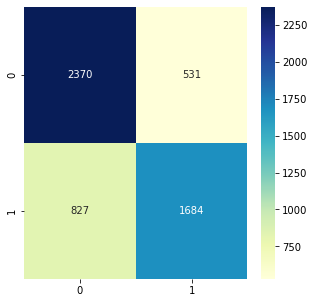

In [44]:
# Confusion Matrix

cm = confusion_matrix(y_test, best_gbc_predictions)

fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu');

In [47]:
# Define Gradient Boosting Classifier with Hyperparameters
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100,max_features=5 )

# Fit train data to GBC
gbc.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, max_features=5, n_estimators=500,
                           random_state=100)

In [48]:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None,
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(learning_rate=0.05, max_features=5, n_estimators=500,
                           random_state=100)

In [49]:
# Confusion matrix will give number of correct and incorrect classifications

print(confusion_matrix(y_test, gbc.predict(X_test)))

[[2831   70]
 [1991  520]]


In [50]:
# Model Accuracy

print("GBC accuracy is %2.2f" % accuracy_score(
    y_test, gbc.predict(X_test)))

GBC accuracy is 0.62


### 5.6 Decision Trees

In [30]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=0)

In [31]:
# Evaluating on Train set
dt_pred_train = dt.predict(X_train)
# Evaluating on Test set
dt_pred_test = dt.predict(X_test)

In [32]:
print(classification_report(y_test, dt_pred_test, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.70      0.73      0.71      2901
    Sarcastic       0.67      0.63      0.65      2511

     accuracy                           0.69      5412
    macro avg       0.68      0.68      0.68      5412
 weighted avg       0.68      0.69      0.68      5412



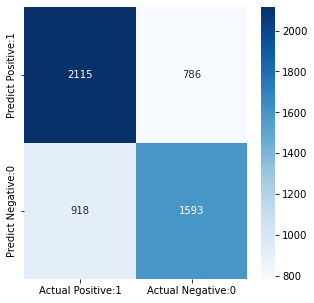

In [33]:
cm = confusion_matrix(y_test, dt_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])


fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues');

### 5.7 Random Forest

In [34]:
# Building  Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', random_state=42)

In [35]:
# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)

In [36]:
print(classification_report(y_test, rfc_pred_test, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.77      0.87      0.82      2901
    Sarcastic       0.82      0.70      0.75      2511

     accuracy                           0.79      5412
    macro avg       0.80      0.78      0.79      5412
 weighted avg       0.79      0.79      0.79      5412



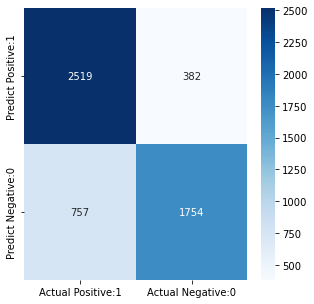

In [37]:
cm = confusion_matrix(y_test, rfc_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])


fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues');

## Conclusion

- **Logistic Regression** model have the highesdt accuracy score at **82%** than **Decision Tree**, **Random Forest** and **Gradient Boosted Decision Tree**.
- **Random Forest** has **79%** accuracy and close to Regression Model since it is also suited to this large dataset.


## Model Improvement
- Use of GridSearch for better tuning with Random Forest and Decision Tree Models

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

In [ ]:
x = 1+1
x

In [ ]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

In [ ]:
show([logistic_regression_global, decision_tree_global])

In [ ]:
from interpret.privacy import DPExplainableBoostingClassifier, DPExplainableBoostingRegressor

dp_ebm = DPExplainableBoostingClassifier(epsilon=1, delta=1e-5) # Specify privacy parameters
dp_ebm.fit(X_train, y_train)

show(dp_ebm.explain_global()) # Identical function calls to standard EBMs

### Submission Requirements

In [ ]:
test_new = X_test

In [ ]:
df_org.columns = ["headline", "prediction"]
df_org.drop(columns = "headline")
df_org.head

predictions = df_org

In [ ]:
res = pd.DataFrame(predictions)

In [ ]:
res.index = predictions.index

In [ ]:
res.columns = ["prediction"]

In [ ]:
res.to_csv("prediction_results.csv", index = False)

In [ ]:
res.head()